# Noisy Qubit Dimensionality Witness

This notebook, optimizes the qubit dimensionality witness when communication between parties is noisy.
Noise models are evaluated over their parameter range to show how the dimensionality witness nonlocality dissipates with respect to noise.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

import context
from QNetOptimizer.gradient_descent import gradient_descent

In [2]:
def _noisy_I3_circuit(channel=None, *channel_params):
    """
    Returns a noisy qubit communication ansatz qnode.
    The circuit prepares three states ρ_x and two measurements
    Π_b^y using the `ArbitraryUnitary` gate.
    Noise is added before measurement in the form of a PennyLane channel operation.
    The returned qnode has the following arguments.

    Args:
        state_params (list[float]) : 3 angle parameters for the arbitrary qubit state.
        measurement_params (list[float]) : 3 angle parameters for the arbitrary measurement.
    """
    dev = qml.device("default.mixed", wires=1)
    
    @qml.qnode(dev)
    def I3_circuit(state_params, measurement_params):
        qml.templates.subroutines.ArbitraryUnitary(state_params, [0])

        if channel != None:
            channel(*channel_params, wires=0)

        qml.templates.subroutines.ArbitraryUnitary(measurement_params, [0])
        return qml.expval(qml.PauliZ(0))
    
    return I3_circuit

def _I3_cost(I3_circuit):
    """
    Returns a cost function for the I3 inequality for the particular ansatz `I3_circuit`.
    The arguments of the returned cost function is specified below.
    
    Args:
        settings (list) : a list containing a 3x3 array of state settings and a 2x3 array of measurement settings.
    """
    def I3_cost(settings):
        B_11 = I3_circuit(settings[0][0], settings[1][0])
        B_12 = I3_circuit(settings[0][0], settings[1][1])
        B_21 = I3_circuit(settings[0][1], settings[1][0])
        B_22 = I3_circuit(settings[0][1], settings[1][1])
        B_31 = I3_circuit(settings[0][2], settings[1][0])
        
        return -(B_11 + B_12 + B_21 - B_22 - B_31)
    
    return I3_cost

def I3_rand_settings():
    """
    Returns a two-element list with the first element being the 3x3 array of state settings and the second being
    2x3 array of measurement settings.
    """
    return [
        2*np.pi*np.random.random((3,3)) - np.pi,
        2*np.pi*np.random.random((2,3)) - np.pi
    ]

## Amplitude Damping Channel

In [3]:
amp_opt_dicts = []
init_settings = I3_rand_settings()
for p in np.arange(0,0.55,0.1):
    settings = init_settings

    circuit = _noisy_I3_circuit(qml.AmplitudeDamping, p)
    cost = _I3_cost(circuit)

    opt_dict = gradient_descent(cost, settings, num_steps=50, verbose=False, sample_width=5)
    
    amp_opt_dicts.append(opt_dict)
    
    print("p = ", p)
    print(opt_dict["opt_score"])
    print(opt_dict["samples"])

p =  0.0
3.8257015737536717
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.1
3.4815750271724175
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.2
3.1862211603883535
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.30000000000000004
2.9222959204395362
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.4
2.659286330341464
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.5
2.371775597376257
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]


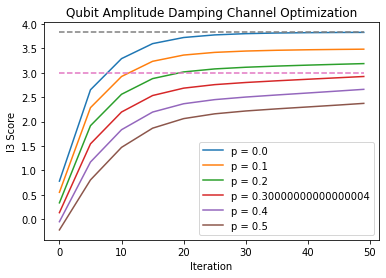

In [4]:
# Plot the score of the Bell inequality
samples = amp_opt_dicts[0]["samples"]
scores = list(map(lambda dict: dict["scores"], amp_opt_dicts))
labels = list(map(lambda p: "p = " + str(p), np.arange(0,0.55,0.1)))

for i in range(len(scores)):
    plt.plot(samples, scores[i], label=labels[i])
    
plt.plot(samples, [3]*len(samples), label = "Classical Bound", linestyle="--")
plt.plot(samples, [1+2*np.sqrt(2)]*len(samples), label = "Quantum Bound", linestyle="--")
plt.title(r"Qubit Amplitude Damping Channel Optimization")
plt.xlabel("Iteration")
plt.ylabel(r"I3 Score")
plt.legend(labels)
plt.show()

## Phase Damping Channel

In [5]:
phase_opt_dicts = []
init_settings = I3_rand_settings()
for p in np.arange(0,0.55,0.1):
    settings = init_settings

    circuit = _noisy_I3_circuit(qml.PhaseDamping, p)
    cost = _I3_cost(circuit)

    opt_dict = gradient_descent(cost, settings, num_steps=50, verbose=False, sample_width=5)
    
    phase_opt_dicts.append(opt_dict)
    
    print("p = ", p)
    print(opt_dict["opt_score"])
    print(opt_dict["samples"])

p =  0.0
3.826595583892499
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.1
3.6520250926043873
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.2
3.4947592701932093
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.30000000000000004
3.365022595721091
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.4
3.256594345174671
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.5
3.1536399228642926
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]


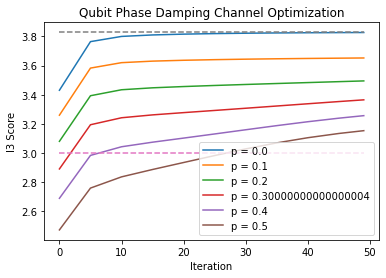

In [6]:
# Plot the score of the Bell inequality
samples = phase_opt_dicts[0]["samples"]
scores = list(map(lambda dict: dict["scores"], phase_opt_dicts))
labels = list(map(lambda p: "p = " + str(p), np.arange(0,0.55,0.1)))

for i in range(len(scores)):
    plt.plot(samples, scores[i], label=labels[i])
    
plt.plot(samples, [3]*len(samples), label = "Classical Bound", linestyle="--")
plt.plot(samples, [1+2*np.sqrt(2)]*len(samples), label = "Quantum Bound", linestyle="--")
plt.title(r"Qubit Phase Damping Channel Optimization")
plt.xlabel("Iteration")
plt.ylabel(r"I3 Score")
plt.legend(labels)
plt.show()

## Depolarizing Channel

In [7]:
depolarizing_opt_dicts = []
init_settings = I3_rand_settings()
for p in np.arange(0,0.55,0.1):
    settings = init_settings

    circuit = _noisy_I3_circuit(qml.DepolarizingChannel, p)
    cost = _I3_cost(circuit)

    opt_dict = gradient_descent(cost, settings, num_steps=50, verbose=False, sample_width=5)
    
    depolarizing_opt_dicts.append(opt_dict)
    
    print("p = ", p)
    print(opt_dict["opt_score"])
    print(opt_dict["samples"])

p =  0.0
3.8277222671264055
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.1
3.3165586442304864
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.2
2.8047441055224973
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.30000000000000004
2.291756152976678
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.4
1.7767993692828732
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.5
1.2590931995206704
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]


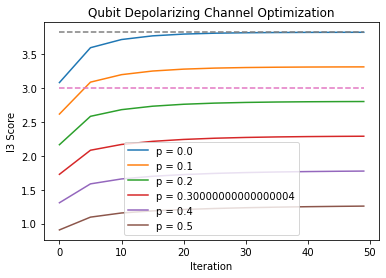

In [8]:
# Plot the score of the Bell inequality
samples = depolarizing_opt_dicts[0]["samples"]
scores = list(map(lambda dict: dict["scores"], depolarizing_opt_dicts))
labels = list(map(lambda p: "p = " + str(p), np.arange(0,0.55,0.1)))

for i in range(len(scores)):
    plt.plot(samples, scores[i], label=labels[i])
    
plt.plot(samples, [3]*len(samples), label = "Classical Bound", linestyle="--")
plt.plot(samples, [1+2*np.sqrt(2)]*len(samples), label = "Quantum Bound", linestyle="--")
plt.title(r"Qubit Depolarizing Channel Optimization")
plt.xlabel("Iteration")
plt.ylabel(r"I3 Score")
plt.legend(labels)
plt.show()

## Bit Flip Channel

In [9]:
flip_opt_dicts = []
init_settings = I3_rand_settings()
for p in np.arange(0,0.55,0.1):
    settings = init_settings

    circuit = _noisy_I3_circuit(qml.BitFlip, p)
    cost = _I3_cost(circuit)

    opt_dict = gradient_descent(cost, settings, num_steps=50, verbose=False, sample_width=5)
    
    flip_opt_dicts.append(opt_dict)
    
    print("p = ", p)
    print(opt_dict["opt_score"])
    print(opt_dict["samples"])

p =  0.0
3.827188158266967
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.1
3.5593886783999653
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.2
3.330538751647047
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.30000000000000004
3.152786791440794
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.4
3.0359761341106775
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.5
2.993323996013851
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]


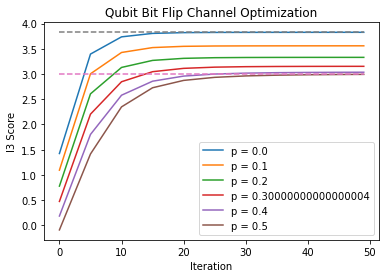

In [10]:
# Plot the score of the Bell inequality
samples = flip_opt_dicts[0]["samples"]
scores = list(map(lambda dict: dict["scores"], flip_opt_dicts))
labels = list(map(lambda p: "p = " + str(p), np.arange(0,0.55,0.1)))

for i in range(len(scores)):
    plt.plot(samples, scores[i], label=labels[i])
    
plt.plot(samples, [3]*len(samples), label = "Classical Bound", linestyle="--")
plt.plot(samples, [1+2*np.sqrt(2)]*len(samples), label = "Quantum Bound", linestyle="--")
plt.title(r"Qubit Bit Flip Channel Optimization")
plt.xlabel("Iteration")
plt.ylabel(r"I3 Score")
plt.legend(labels)
plt.show()

## Phase Flip Channel

In [11]:
phase_flip_opt_dicts = []
init_settings = I3_rand_settings()
for p in np.arange(0,0.55,0.1):
    settings = init_settings

    circuit = _noisy_I3_circuit(qml.BitFlip, p)
    cost = _I3_cost(circuit)

    opt_dict = gradient_descent(cost, settings, num_steps=50, verbose=False, sample_width=5)
    
    phase_flip_opt_dicts.append(opt_dict)
    
    print("p = ", p)
    print(opt_dict["opt_score"])
    print(opt_dict["samples"])

p =  0.0
3.8264986884487193
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.1
3.478413232763807
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.2
3.264157567393114
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.30000000000000004
3.092115028010717
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.4
2.988506146584139
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.5
2.976156485061174
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]


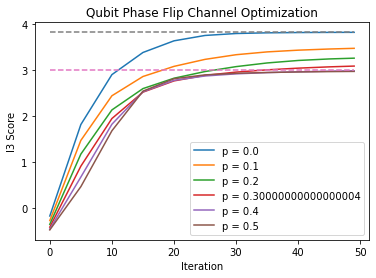

In [15]:
# Plot the score of the Bell inequality
samples = phase_flip_opt_dicts[0]["samples"]
scores = list(map(lambda dict: dict["scores"], phase_flip_opt_dicts))
labels = list(map(lambda p: "p = " + str(p), np.arange(0,0.55,0.1)))

for i in range(len(scores)):
    plt.plot(samples, scores[i], label=labels[i])
    
plt.plot(samples, [3]*len(samples), label = "Classical Bound", linestyle="--")
plt.plot(samples, [1+2*np.sqrt(2)]*len(samples), label = "Quantum Bound", linestyle="--")
plt.title(r"Qubit Phase Flip Channel Optimization")
plt.xlabel("Iteration")
plt.ylabel(r"I3 Score")
plt.legend(labels)
plt.show()

## Reset Error Channel

In [13]:
reset_opt_dicts = []
init_settings = I3_rand_settings()
for p in np.arange(0,0.55,0.1):
    settings = init_settings

    circuit = _noisy_I3_circuit(qml.BitFlip, p)
    cost = _I3_cost(circuit)

    opt_dict = gradient_descent(cost, settings, num_steps=50, verbose=False, sample_width=5)
    
    reset_opt_dicts.append(opt_dict)
    
    print("p = ", p)
    print(opt_dict["opt_score"])
    print(opt_dict["samples"])

p =  0.0
3.8270189118339295
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.1
3.465005586019247
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.2
3.267547125446068
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.30000000000000004
3.1140787052287084
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.4
2.995663383299423
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]
p =  0.5
2.986087454889639
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 49]


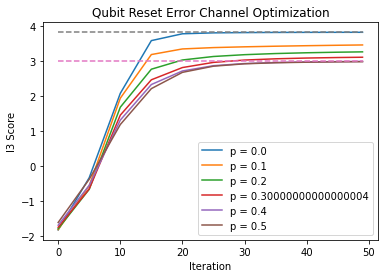

In [14]:
# Plot the score of the Bell inequality
samples = reset_opt_dicts[0]["samples"]
scores = list(map(lambda dict: dict["scores"], reset_opt_dicts))
labels = list(map(lambda p: "p = " + str(p), np.arange(0,0.55,0.1)))

for i in range(len(scores)):
    plt.plot(samples, scores[i], label=labels[i])
    
plt.plot(samples, [3]*len(samples), label = "Classical Bound", linestyle="--")
plt.plot(samples, [1+2*np.sqrt(2)]*len(samples), label = "Quantum Bound", linestyle="--")
plt.title(r"Qubit Reset Error Channel Optimization")
plt.xlabel("Iteration")
plt.ylabel(r"I3 Score")
plt.legend(labels)
plt.show()